In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np
from datetime import timedelta
import seaborn as sns
import os
from scipy import stats




In [3]:
vcb = pd.read_csv("vcb_2010-2024.csv")
vcb['Date'] = pd.to_datetime(vcb['Date'], dayfirst=True)
vcb = vcb[::-1].reset_index(drop=True)
vcb.set_index('Date', inplace=True)
vcb


/tmp/ipykernel_219/2237522829.py:2: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  vcb['Date'] = pd.to_datetime(vcb['Date'], dayfirst=True)


,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,13842,14519,13842,14519,2032674
2010-01-05,15020,15167,14519,14667,3175256
2010-01-06,14166,14667,14136,14136,1629290
2010-01-07,14136,14166,13842,13842,704530
2010-01-08,14019,14078,13812,13842,1193887
...,...,...,...,...,...
2024-05-27,90400,90600,89700,90200,1258620
2024-05-28,89800,90700,89800,90700,1814349
2024-05-29,90800,91000,89800,89800,1186438


In [5]:
vcb['returns'] = 100 * vcb.Close.pct_change().dropna()


In [6]:
vcb['log_returns'] = np.log(vcb.Close/vcb.Close.shift(1))


In [7]:
vcb.head()

,Open,High,Low,Close,Volume,returns,log_returns
Date,,,,,,,
2010-01-04,13842,14519,13842,14519,2032674,NaN,NaN
2010-01-05,15020,15167,14519,14667,3175256,1.019354,0.010142
2010-01-06,14166,14667,14136,14136,1629290,-3.620372,-0.036875
2010-01-07,14136,14166,13842,13842,704530,-2.079796,-0.021017
2010-01-08,14019,14078,13812,13842,1193887,0.000000,0.000000


In [8]:
vcb.dropna(inplace=True)

/tmp/ipykernel_219/3822297024.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vcb.returns, norm_hist=True, fit=stats.norm, color='blue',
/tmp/ipykernel_219/3822297024.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vcb.log_returns, norm_hist=True, fit=stats.norm, color='green',


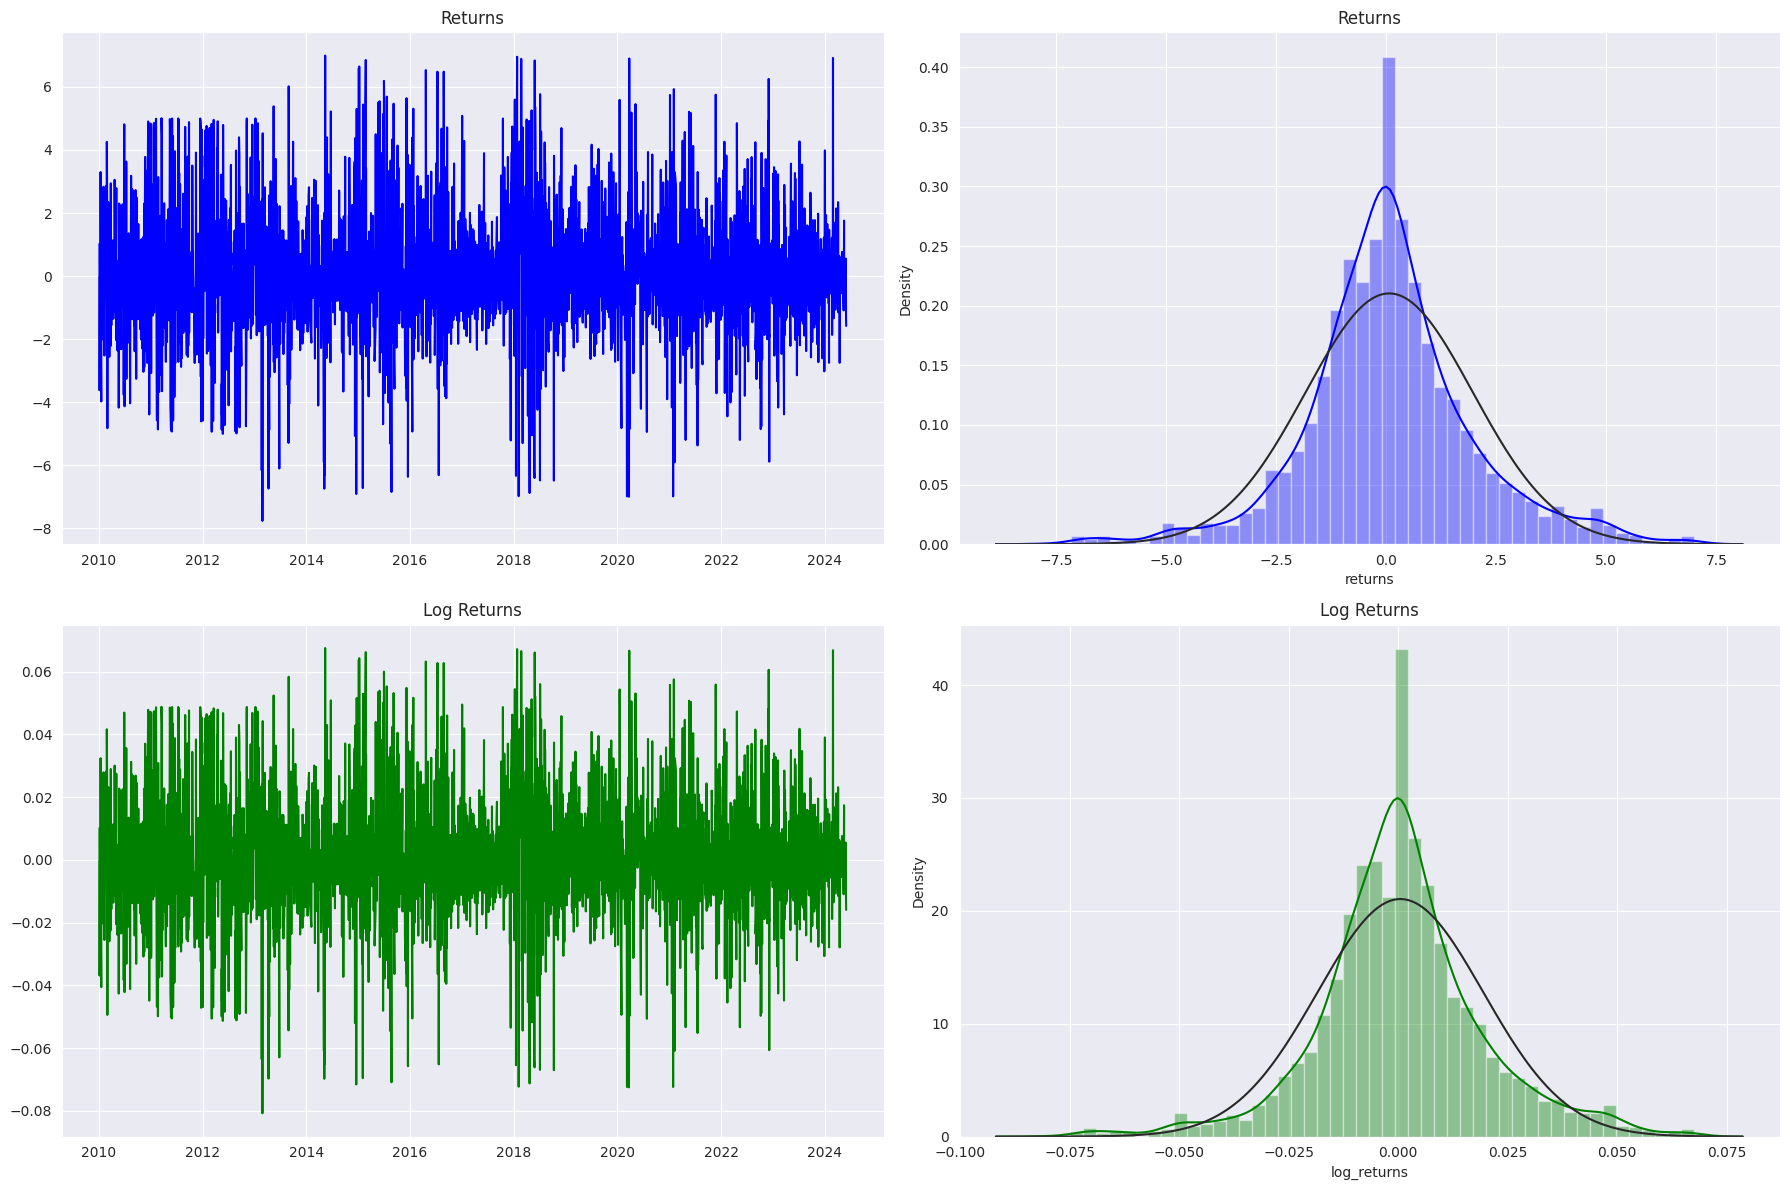

In [13]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(vcb.returns, color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(vcb.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Returns')

    axes[1][0].plot(vcb.log_returns, color='green')
    axes[1][0].set_title('Log Returns')

    sns.distplot(vcb.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    plt.tight_layout()
    
    fig.show();

In [14]:
vcb.returns.describe()

count    3591.000000
mean        0.067912
std         1.897321
min        -7.758922
25%        -0.931974
50%         0.000000
75%         0.967136
max         6.989506
Name: returns, dtype: float64

In [15]:
vcb.log_returns.describe()

count    3591.000000
mean        0.000499
std         0.018959
min        -0.080765
25%        -0.009363
50%         0.000000
75%         0.009625
max         0.067561
Name: log_returns, dtype: float64

Tính độ lệch chuẩn hàng ngày

In [16]:
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [17]:
intervals = [7, 30, 60, 180, 365]
vols_vcb = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = vcb.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_vcb[i] = vols

# CONVERT vols_vcb FROM DICTIONARY TO PANDAS DATAFRAME
vols_vcb = pd.DataFrame(vols_vcb, columns=intervals, index=vcb.index)

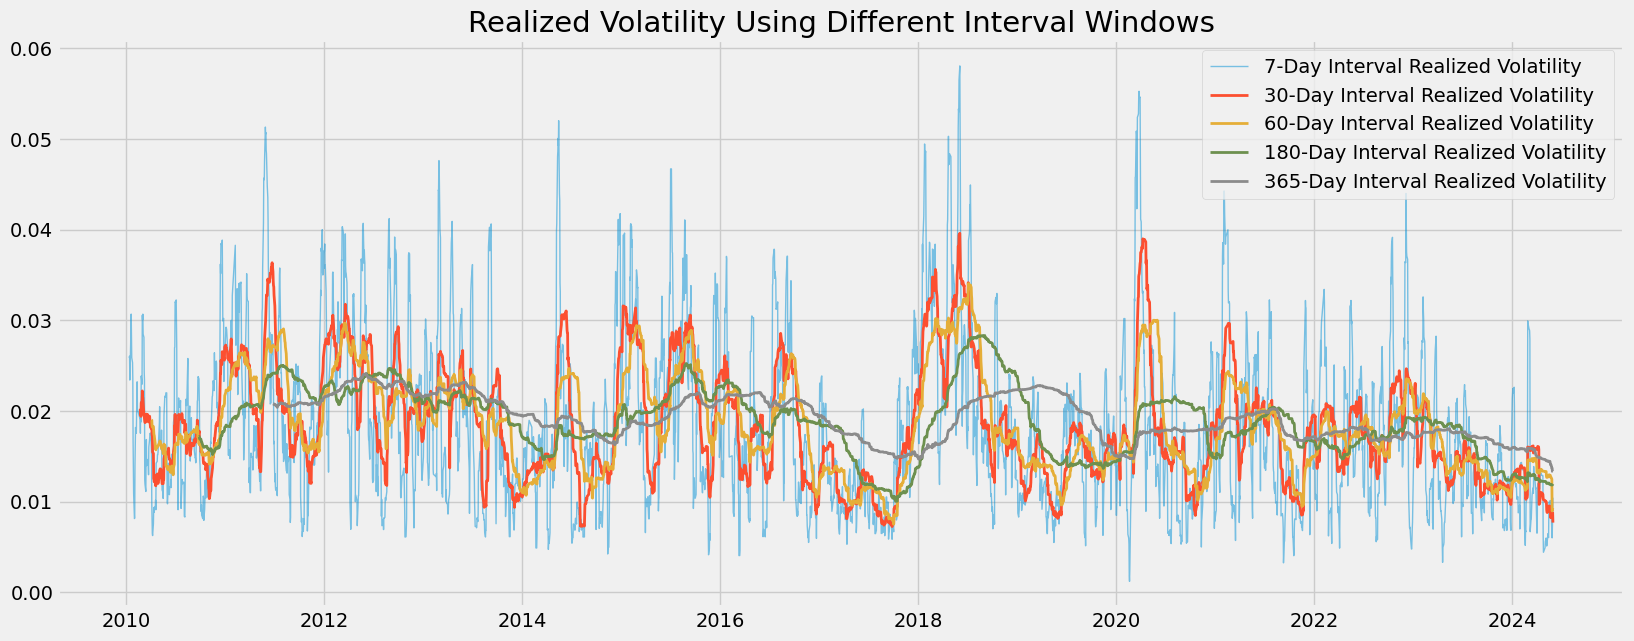

In [18]:
# CHANGING MATPLOTLIB STYLE
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_vcb[i], label=f'{i}-Day Interval Realized Volatility', 
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})

plt.show();

In [19]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
vcb['vol_current'] = vcb.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
vcb['vol_future'] = vcb.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)
vcb.describe()

,Open,High,Low,Close,Volume,returns,log_returns,vol_current,vol_future
count,3591.000000,3591.000000,3591.000000,3591.000000,3.591000e+03,3591.000000,3591.000000,3562.000000,3555.000000
mean,36625.942913,37060.031189,36209.322194,36645.310220,1.736991e+06,0.067912,0.000499,0.018257,0.018253
std,25530.923841,25790.472755,25254.412656,25540.231955,1.445331e+06,1.897321,0.018959,0.006282,0.006287
min,8292.000000,8463.000000,8292.000000,8292.000000,4.627400e+04,-7.758922,-0.080765,0.007254,0.007254
25%,12780.000000,12905.500000,12664.000000,12780.000000,8.427520e+05,-0.931974,-0.009363,0.013619,0.013609
50%,25183.000000,25449.000000,24885.000000,25084.000000,1.403986e+06,0.000000,0.000000,0.017070,0.017033
75%,59265.500000,59856.000000,58927.000000,59325.000000,2.190265e+06,0.967136,0.009625,0.021815,0.021817
max,98500.000000,100500.000000,97300.000000,97400.000000,3.407681e+07,6.989506,0.067561,0.039603,0.039603


In [ ]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)
# plt.style.use(['seaborn'])

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(vcb.vol_current, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(vcb.vol_future, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(vcb.vol_current[-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(vcb.vol_future[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()
    plt.show();

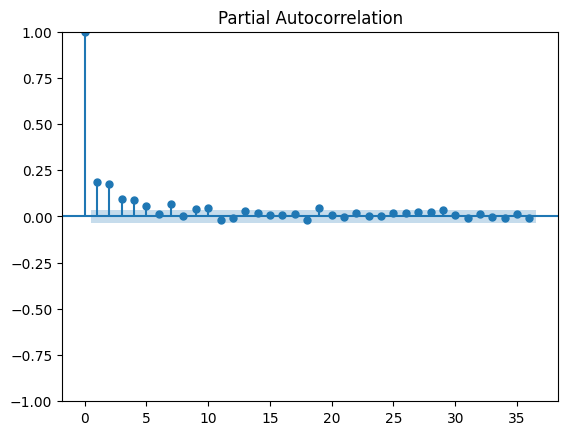

In [4]:
plot_pacf(returns**2)
plt.show()

In [14]:
model = arch_model(returns, p=3, q=3)
model_fit = model.fit()
print(model_fit.summary())

Iteration:      1,   Func. Count:     10,   Neg. LLF: 10555.698254775874
Iteration:      2,   Func. Count:     23,   Neg. LLF: 10120.930496351233
Iteration:      3,   Func. Count:     34,   Neg. LLF: 10731.974490487491
Iteration:      4,   Func. Count:     45,   Neg. LLF: 7353.2749044739285
Iteration:      5,   Func. Count:     56,   Neg. LLF: 9510.47302661485
Iteration:      6,   Func. Count:     66,   Neg. LLF: 7207.806740035965
Iteration:      7,   Func. Count:     76,   Neg. LLF: 7235.164100589859
Iteration:      8,   Func. Count:     86,   Neg. LLF: 7174.672693776199
Iteration:      9,   Func. Count:     96,   Neg. LLF: 7163.211405739977
Iteration:     10,   Func. Count:    106,   Neg. LLF: 7162.282977284965
Iteration:     11,   Func. Count:    115,   Neg. LLF: 7161.815445534625
Iteration:     12,   Func. Count:    124,   Neg. LLF: 7161.800984136332
Iteration:     13,   Func. Count:    133,   Neg. LLF: 7161.800391903125
Iteration:     14,   Func. Count:    142,   Neg. LLF: 7161.80

In [6]:
model = arch_model(returns, p=3, q=0)
model_fit = model.fit()
print(model_fit.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 11882.89581938065
Iteration:      2,   Func. Count:     17,   Neg. LLF: 20198.06128792857
Iteration:      3,   Func. Count:     26,   Neg. LLF: 9663.692238914859
Iteration:      4,   Func. Count:     33,   Neg. LLF: 79032.71939496326
Iteration:      5,   Func. Count:     40,   Neg. LLF: 8154.6334104715
Iteration:      6,   Func. Count:     48,   Neg. LLF: 7489.3180948463705
Iteration:      7,   Func. Count:     56,   Neg. LLF: 7224.300885433879
Iteration:      8,   Func. Count:     62,   Neg. LLF: 7224.229370724146
Iteration:      9,   Func. Count:     68,   Neg. LLF: 7224.228196620692
Iteration:     10,   Func. Count:     74,   Neg. LLF: 7224.226668454292
Iteration:     11,   Func. Count:     80,   Neg. LLF: 7224.226665138448
Iteration:     12,   Func. Count:     85,   Neg. LLF: 7224.226665138265
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7224.226665138448
            Iterations: 12
  

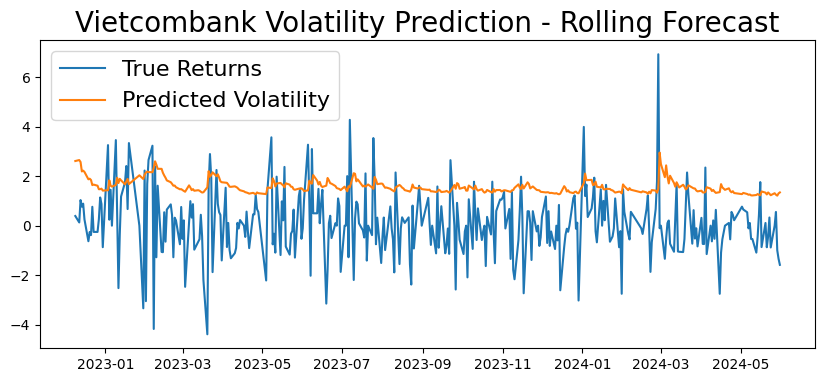

In [15]:
rolling_predictions = []
test_size = 365  # Adjust as needed

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=3, q=3)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-test_size:])
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-test_size:])
preds, = plt.plot(rolling_predictions)
plt.title('Vietcombank Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)
plt.show()


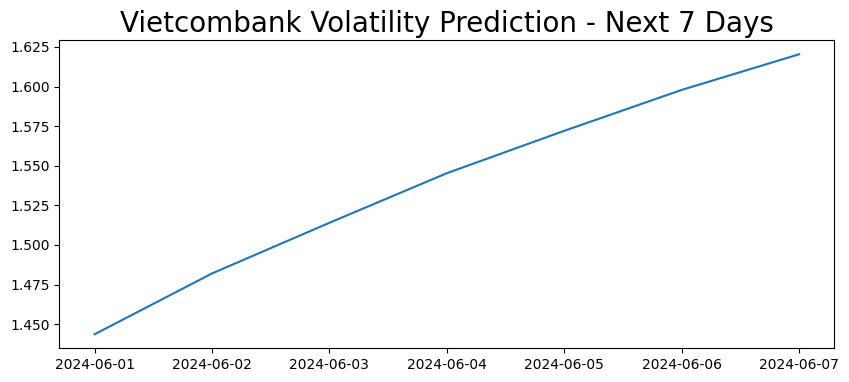

In [8]:
train = returns
model = arch_model(train, p=2, q=2)
model_fit = model.fit(disp='off')
pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1, 8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1, :]), index=future_dates)

plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Vietcombank Volatility Prediction - Next 7 Days', fontsize=20)
plt.show()


# Bài của Freecodecamp


In [17]:
# Tính toán log return hàng ngày
vcb['log_ret'] = np.log(vcb['Close']).diff()

# Tính toán phương sai lăn 6 tháng
vcb['variance'] = vcb['log_ret'].rolling(180).var()

# Lọc dữ liệu từ năm 2020
vcb = vcb['2020':]
vcb.head()

,Open,High,Low,Close,Volume,log_ret,variance
Date,,,,,,,
2020-01-02,59856,60652,59524,60254,582122,0.006627,0.000205
2020-01-03,60718,60918,59657,59657,807924,-0.009957,0.000206
2020-01-06,59192,59391,58064,58064,1326287,-0.027066,0.000210
2020-01-07,57732,58330,56671,58263,1691709,0.003421,0.000210
2020-01-08,57666,58330,57201,57732,1269279,-0.009156,0.000210


In [18]:
vcb

,Open,High,Low,Close,Volume,log_ret,variance
Date,,,,,,,
2020-01-02,59856,60652,59524,60254,582122,0.006627,0.000205
2020-01-03,60718,60918,59657,59657,807924,-0.009957,0.000206
2020-01-06,59192,59391,58064,58064,1326287,-0.027066,0.000210
2020-01-07,57732,58330,56671,58263,1691709,0.003421,0.000210
2020-01-08,57666,58330,57201,57732,1269279,-0.009156,0.000210
...,...,...,...,...,...,...,...
2024-05-27,90400,90600,89700,90200,1258620,0.000000,0.000141
2024-05-28,89800,90700,89800,90700,1814349,0.005528,0.000140
2024-05-29,90800,91000,89800,89800,1186438,-0.009972,0.000141


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004308. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004321. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarn

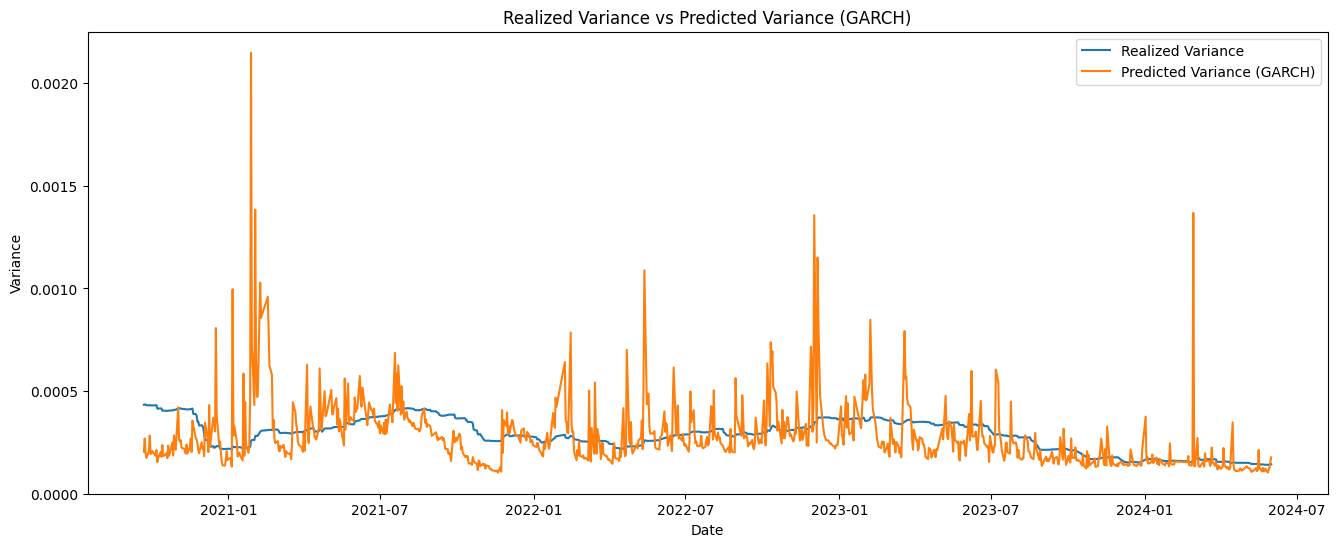

In [19]:
# Hàm dự đoán biến động bằng mô hình GARCH
def predict_volatility(x):
    best_model = arch_model(y=x, p=1, q=3).fit(update_freq=5, disp='off')
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    return variance_forecast

# Áp dụng mô hình GARCH để dự đoán biến động
vcb['predictions'] = vcb['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

# Loại bỏ giá trị NaN
vcb = vcb.dropna()

# Vẽ biểu đồ dự đoán biến động so với phương sai thực tế
plt.figure(figsize=(16, 6))
plt.plot(vcb.index, vcb['variance'], label='Realized Variance')
plt.plot(vcb.index, vcb['predictions'], label='Predicted Variance (GARCH)')
plt.title('Realized Variance vs Predicted Variance (GARCH)')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.legend()
plt.show()


/tmp/ipykernel_250/2574368423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vcb['prediction_premium'] = (vcb['predictions'] - vcb['variance']) / vcb['variance']
/tmp/ipykernel_250/2574368423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vcb['premium_std'] = vcb['prediction_premium'].rolling(180).std()
/tmp/ipykernel_250/2574368423.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

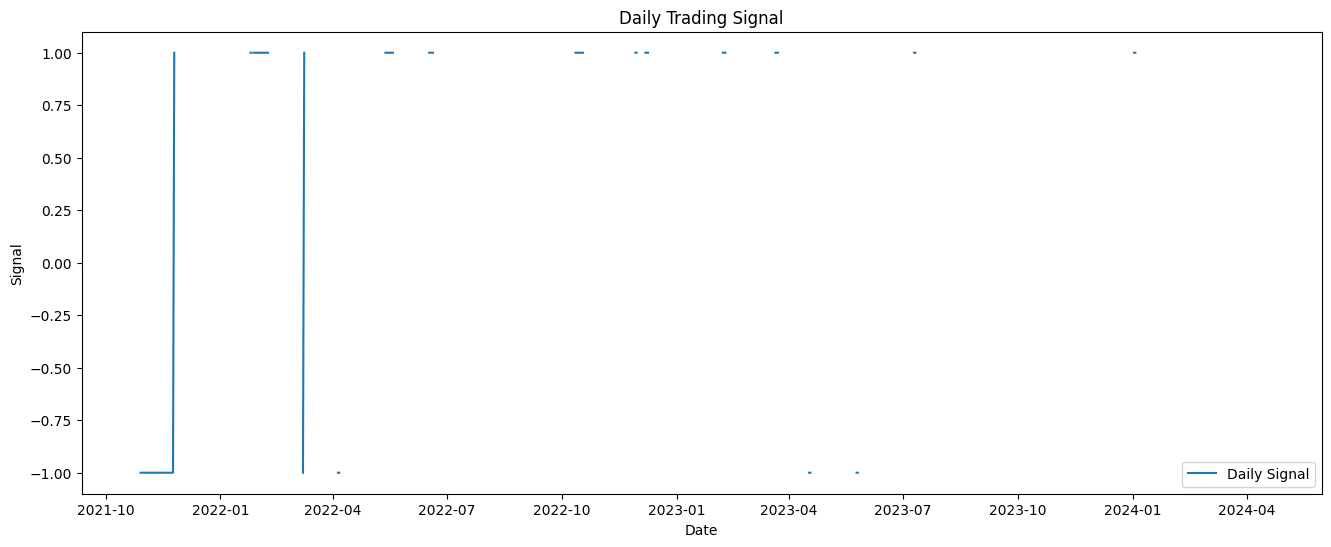

In [20]:
# Tính toán dự đoán premium và phương sai lăn
vcb['prediction_premium'] = (vcb['predictions'] - vcb['variance']) / vcb['variance']
vcb['premium_std'] = vcb['prediction_premium'].rolling(180).std()

# Tạo tín hiệu hàng ngày
vcb['signal_daily'] = vcb.apply(lambda x: 1 if x['prediction_premium'] > x['premium_std']
                                else (-1 if x['prediction_premium'] < x['premium_std'] * -1 else np.nan), axis=1)

# Shift tín hiệu để tránh look-ahead bias
vcb['signal_daily'] = vcb['signal_daily'].shift()

# Vẽ biểu đồ tín hiệu hàng ngày
plt.figure(figsize=(16, 6))
plt.plot(vcb.index, vcb['signal_daily'], label='Daily Signal')
plt.title('Daily Trading Signal')
plt.xlabel('Date')
plt.ylabel('Signal')
plt.legend()
plt.show()

/tmp/ipykernel_250/2100454840.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vcb['return'] = np.log(vcb['Close']).diff()
/tmp/ipykernel_250/2100454840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vcb['strategy_return'] = vcb['return'] * vcb['signal_daily']
/tmp/ipykernel_250/2100454840.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

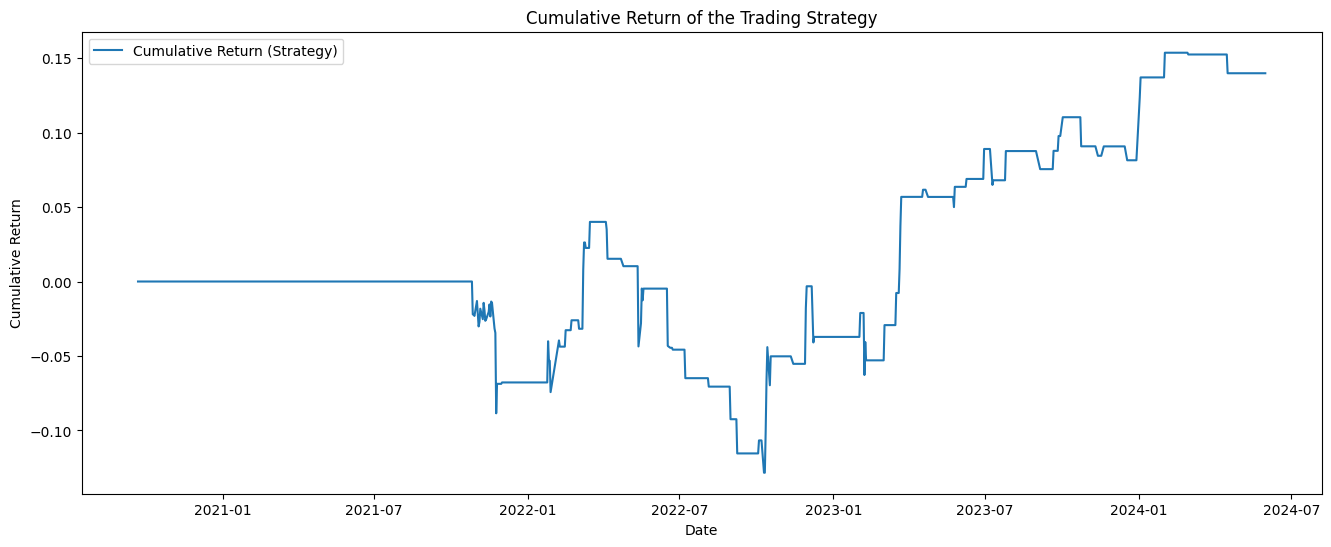

,Close,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily,strategy_return,cumulative_return
Date,,,,,,,,,
2020-09-22,55742,0.011984,0.000433,0.000205,-0.527374,NaN,NaN,0.0,0.000000
2020-09-23,56671,0.016529,0.000435,0.000269,-0.382063,NaN,NaN,0.0,0.000000
2020-09-24,57135,0.008154,0.000434,0.000199,-0.542364,NaN,NaN,0.0,0.000000
2020-09-25,57069,-0.001156,0.000430,0.000173,-0.597589,NaN,NaN,0.0,0.000000
2020-09-28,57069,0.000000,0.000430,0.000208,-0.517443,NaN,NaN,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
2024-05-27,90200,0.000000,0.000141,0.000102,-0.276386,0.570550,NaN,0.0,0.139847
2024-05-28,90700,0.005528,0.000140,0.000116,-0.174325,0.570569,NaN,0.0,0.139847
2024-05-29,89800,-0.009972,0.000141,0.000127,-0.099126,0.570340,NaN,0.0,0.139847


In [21]:
# Tạo vị thế giao dịch và tính toán lợi nhuận chiến lược
vcb['return'] = np.log(vcb['Close']).diff()
vcb['strategy_return'] = vcb['return'] * vcb['signal_daily']
vcb['strategy_return'] = vcb['strategy_return'].fillna(0)

# Tính toán lợi nhuận tích lũy của chiến lược
vcb['cumulative_return'] = np.exp(np.log1p(vcb['strategy_return']).cumsum()) - 1

# Vẽ biểu đồ lợi nhuận tích lũy của chiến lược
plt.figure(figsize=(16, 6))
plt.plot(vcb.index, vcb['cumulative_return'], label='Cumulative Return (Strategy)')
plt.title('Cumulative Return of the Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Hiển thị kết quả cuối cùng
vcb[['Close', 'log_ret', 'variance', 'predictions', 'prediction_premium', 'premium_std', 'signal_daily', 'strategy_return', 'cumulative_return']]


In [43]:
# Tính toán các chỉ số lỗi dự báo
mse = mean_squared_error(vcb['log_ret'], vcb['predictions'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(vcb['log_ret'], vcb['predictions'])

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


MSE: 0.0002671254222508855
RMSE: 0.016343972046319877
MAE: 0.011803695513804124


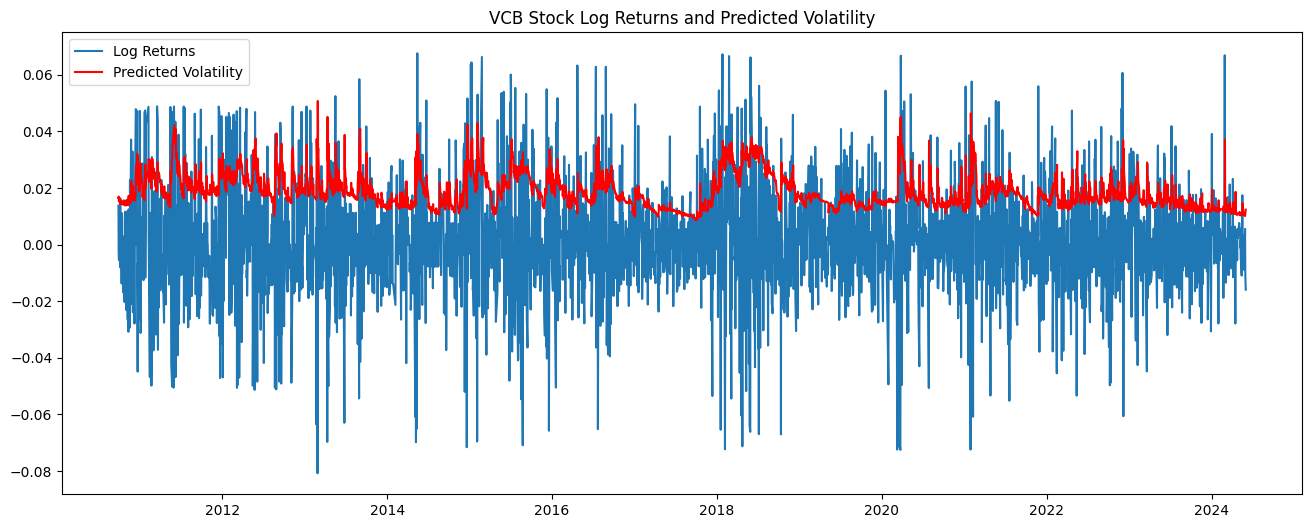

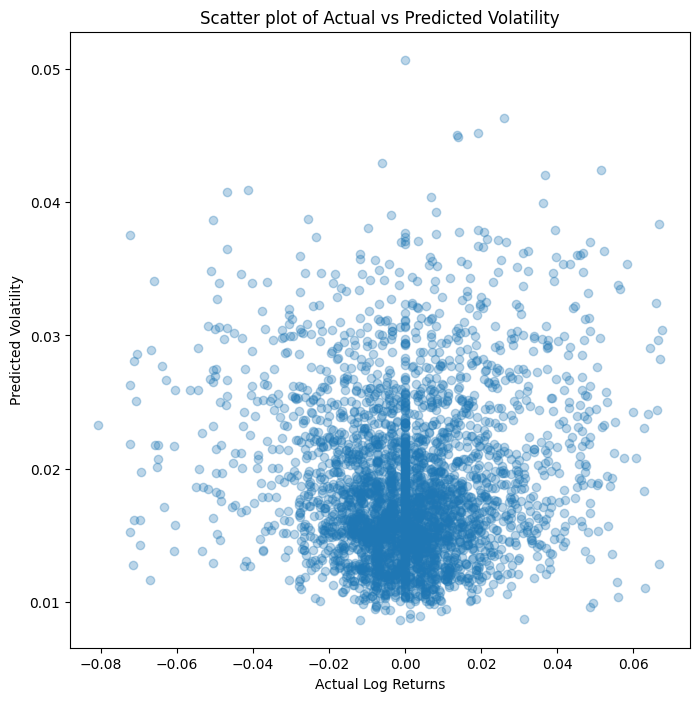

In [38]:
# Vẽ biểu đồ biến động dự đoán
plt.figure(figsize=(16, 6))
plt.plot(vcb.index, vcb['log_ret'], label='Log Returns')
plt.plot(vcb.index, vcb['predicted_vol'], label='Predicted Volatility', color='red')
plt.title('VCB Stock Log Returns and Predicted Volatility')
plt.legend()
plt.show()

# Biểu đồ phân tán
plt.figure(figsize=(8, 8))
plt.scatter(vcb['log_ret'], vcb['predicted_vol'], alpha=0.3)
plt.xlabel('Actual Log Returns')
plt.ylabel('Predicted Volatility')
plt.title('Scatter plot of Actual vs Predicted Volatility')
plt.show()


In [44]:
# Tính toán dấu của lợi nhuận log thực tế và biến động dự đoán
vcb['actual_sign'] = np.sign(vcb['log_ret'])
vcb['predicted_sign'] = np.sign(vcb['predictions'])

# Tính toán tỷ lệ phần trăm dự đoán đúng dấu
accuracy = (vcb['actual_sign'] == vcb['predicted_sign']).mean()

print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 46.80%


In [7]:
from arch import arch_model
import matplotlib.pyplot as plt
vcb['log_ret'] = np.log(vcb['Close']).diff().dropna()

# Chỉ giữ dữ liệu từ năm 2020

# Tính phương sai cuộn 180 ngày
vcb['variance'] = vcb['log_ret'].rolling(180).var()

# Hàm dự báo biến động sử dụng mô hình GARCH
def predict_volatility(x):
    best_model = arch_model(y=x * 100, p=1, q=3).fit(update_freq=5, disp='off')
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    return variance_forecast

# Áp dụng hàm dự báo biến động trên cửa sổ cuộn 180 ngày
vcb['predictions'] = vcb['log_ret'].rolling(180).apply(lambda x: predict_volatility(x), raw=False)

# Loại bỏ các giá trị thiếu
vcb = vcb.dropna()

# Hiển thị dữ liệu đã xử lý
vcb

,Open,High,Low,Close,Volume,log_ret,variance,predictions
Date,,,,,,,,
2010-09-27,11424,11424,11298,11330,420541,-0.013762,0.000293,2.702760
2010-09-28,11267,11487,11267,11487,367382,0.013762,0.000294,2.874801
2010-09-29,11361,11487,11298,11456,193795,-0.002702,0.000287,2.327684
2010-09-30,11519,11519,11267,11393,819730,-0.005514,0.000285,2.226632
2010-10-01,11330,11456,11298,11330,170727,-0.005545,0.000285,2.167144
...,...,...,...,...,...,...,...,...
2024-05-27,90400,90600,89700,90200,1258620,0.000000,0.000141,1.017278
2024-05-28,89800,90700,89800,90700,1814349,0.005528,0.000140,1.156475
2024-05-29,90800,91000,89800,89800,1186438,-0.009972,0.000141,1.266499


In [5]:
vcb[:30]

,Open,High,Low,Close,Volume,log_ret,variance,predictions
Date,,,,,,,,
2010-09-27,11424,11424,11298,11330,420541,-0.013762,0.000293,0.000284
2010-09-28,11267,11487,11267,11487,367382,0.013762,0.000294,0.000288
2010-09-29,11361,11487,11298,11456,193795,-0.002702,0.000287,0.000233
2010-09-30,11519,11519,11267,11393,819730,-0.005514,0.000285,0.000254
2010-10-01,11330,11456,11298,11330,170727,-0.005545,0.000285,0.000249
2010-10-04,11456,11456,11298,11330,950356,0.000000,0.000285,0.000206
2010-10-05,11267,11393,11267,11393,677442,0.005545,0.000279,0.000213
2010-10-06,11393,11581,11393,11581,1230135,0.016367,0.000275,0.000251
2010-10-07,11581,11581,11456,11487,476433,-0.008150,0.000274,0.000239
